# IBM Open Science Prize 2022 

**Group:** _Stefan Sack, Stefano Barison_

In [1]:
## TODO: little introduction?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 1 - Classical simulation 

In [3]:
# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

In [4]:
# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

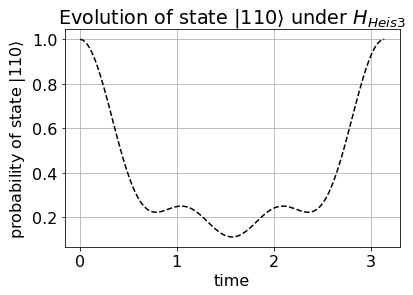

In [5]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110_exact = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.grid()
plt.show()

## 2- The Open Science Prize

The aim is to time evolve the state $|110\rangle$ to time $t=\pi$ under the $XXX$ Heisenberg model Hamiltonian $H_{\text{heis3}}$. The evolution must be done using Trotterization with at least 4 steps ($n\geq4$).

### 2.1 - Trotterization comparison

For this reason, we will start analysing how a Trotterization on a perfect quantum device will evolve the state $|110\rangle$ to time $t=\pi$ given a fixed number of Trotter steps.

In [6]:
## Import functions from Qiskit
from qiskit                     import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, Aer
from qiskit.providers.aer       import QasmSimulator
from qiskit.tools.monitor       import job_monitor
from qiskit.circuit             import Parameter, ParameterVector
from qiskit.quantum_info        import Statevector, Pauli
from qiskit.opflow.state_fns    import CircuitStateFn
from qiskit.opflow.expectations import PauliExpectation
from qiskit.utils               import QuantumInstance
from qiskit.opflow              import PauliOp, SummedOp, CircuitSampler, StateFn

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info                  import state_fidelity

In [7]:
## In the "trotter_function.py" file are contained all the functions useful for a perfect Trotter simulation
from trotter_functions import Heisenberg_Trotter

In [8]:
## Let's simulate the system with a different number of Trotter steps and compare with the matrix exponentiation
t_steps = [4,8,12]
probs_110_trott = {4:[],8:[],12:[]}
t = Parameter("t")

for t_n in t_steps:
    for sim_t in ts:
        # Initialise the circuit
        trott_qr = QuantumRegister(3)
        trott_qc = QuantumCircuit(trott_qr)
        trott_qc.x([1,2])
    
        # Append the Trotterization
        trott_step = Heisenberg_Trotter(num_qubits=3,trotter_steps=t_n,p=t,target_time=sim_t).to_instruction()
        trott_qc.append(trott_step, [trott_qr[0], trott_qr[1], trott_qr[2]])
    
    
        trott_wfn = CircuitStateFn(trott_qc)
        trott_ovp = np.abs((~initial_state@trott_wfn).eval())**2
        probs_110_trott[t_n].append(trott_ovp)
    print(str(t_n)+" steps completed")

4 steps completed
8 steps completed
12 steps completed


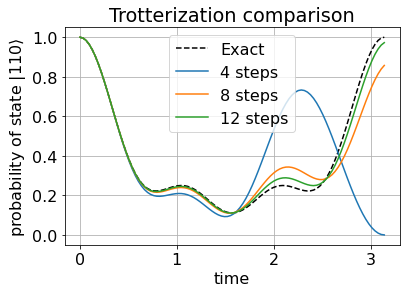

In [9]:
# Now plot the comparison
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
for (i,t_n) in enumerate(t_steps):
    plt.plot(ts, probs_110_trott[t_n],color="C"+str(i),label=str(t_n)+" steps")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Trotterization comparison')
plt.legend()
plt.grid()
plt.show()

As we can see, four Trotter steps are not enough to correctly time evolve the target state to $t=\pi$.
As expected, increasing the Trotter steps we get closer and closer to the exact simulation.

However, we are limited in the circuit depth that we can implement on hardware. For this reason, the aim of this notebook will be to compress the greatest Trotterization accuracy into the shortest possible circuit, before even applying error mitigation techniques.

### 2.2 Compress the Trotter step

The first step is to reduce the number of gates required by a single Trotter step. 
To this point, a single Trotter step requires $12$ CNOTs.

We can easily reduce it to $6$ using an optimal circuit for the $XX+YY+ZZ$ rotation presented in [Quantum computers as universal quantum simulators: state-of-art and perspectives](https://arxiv.org/abs/1907.03505).

In particular, we will consider the decomposition in Fig. 4b, while the initial Trotterization corresponds to the decomposition in Fig. 4a.

With this decomposition, 4 Trotter steps on 3 qubits will now require 24 CNOTs instead of 48.

In [10]:
# import the compressed Trotterization
from trotter_functions import Heisenberg_Trotter_compressed

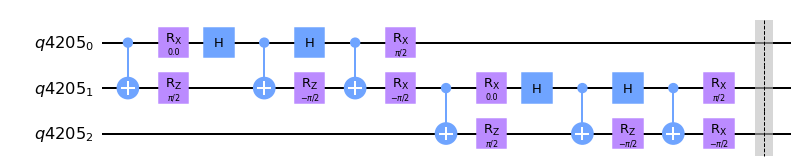

In [12]:
## Ad an example of the new Trotter step

compression_example = Heisenberg_Trotter_compressed(num_qubits=3,trotter_steps=1,p=t,target_time=np.pi/4)
compression_example.decompose().decompose().draw(output='mpl')

To show that the two decompositions are equivalent, let us simulate again the system with $4$ steps up to $t=\pi$.

In [13]:
probs_110_trott_c = []
for sim_t in ts:
    # Initialise the circuit
    trott_qr_c = QuantumRegister(3)
    trott_qc_c = QuantumCircuit(trott_qr_c)
    trott_qc_c.x([1,2])
    
    # Append the Trotterization
    trott_step_c = Heisenberg_Trotter_compressed(num_qubits=3,trotter_steps=4,p=t,target_time=sim_t).to_instruction()
    trott_qc_c.append(trott_step_c, [trott_qr_c[0], trott_qr_c[1], trott_qr_c[2]])
    
    
    trott_wfn_c = CircuitStateFn(trott_qc_c)
    trott_ovp_c = np.abs((~initial_state@trott_wfn_c).eval())**2
    probs_110_trott_c.append(trott_ovp_c)

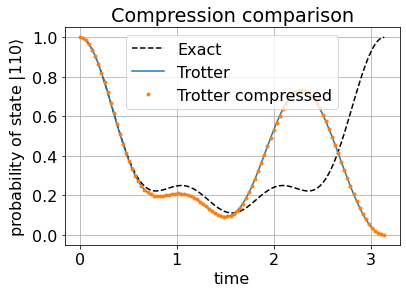

In [14]:
## Now plot the exact simulation, the initial Trotter and the Trotter compressed
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
plt.plot(ts, probs_110_trott[4],color="C0",label="Trotter")
plt.plot(ts, probs_110_trott_c,color="C1",marker=".",linestyle="",label="Trotter compressed")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Compression comparison')
plt.legend()
plt.grid()
plt.show()

As can be seen, the two circuits give the exact same probability at all times!

### Using the Yang - Baxter Equivalence (YBE) 

The circuit now has 24 CNOTs which is already very good, though it can be compressed even further! To this end we will be using the [Yang-Baxter Equation](https://www.worldscientific.com/doi/epdf/10.1142/S0217751X89001503) (YBE) which has recently been used by [Gulania et. al](https://arxiv.org/pdf/2112.01690.pdf) to compress the circuit for a Trotterized time evolution of the XY Heisenberg model. 

The YBE equation works in the following way:

--- Put the image of the method

Unfortunately, the paper doesn't present an analytical relationship between the Trotter circuit and the YBE-compressed circuit when considering the XXX Hamiltonian, even if that is conjectured to exist.

We propose to find this equivalence variationally.

We want to highlight that we are not going to use these parameters in the final circuit.
The aim of this section is to demonstrate that at every time $t$ a set of parameters can be found in order for the YBE circuit to be equivalent to the Trotter one. Even if the relationship is not known analitically, we find it variationally. 

In [15]:
# Import the YBE circuit 
from trotter_functions import Heisenberg_YBE_variational

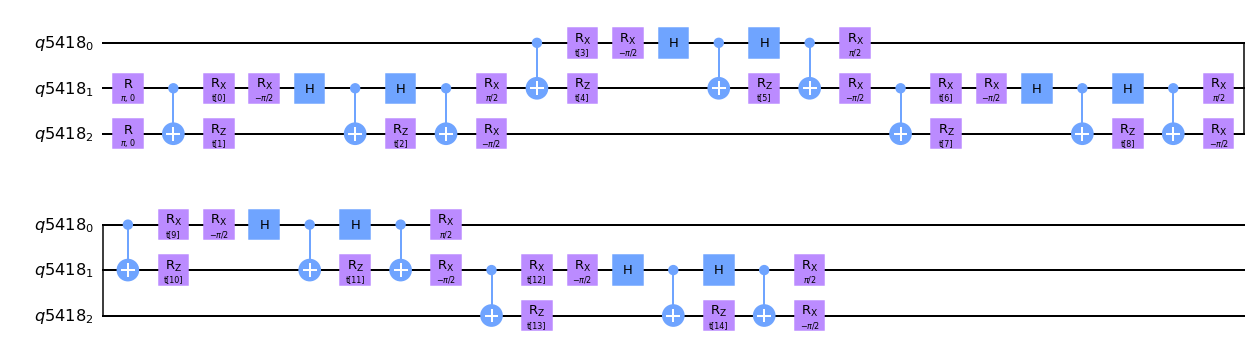

In [18]:
# Here we show an example of the circuit
example = Heisenberg_YBE_variational(3,ParameterVector('t',15))
example.decompose().draw(output='mpl')

At every time $t$, we want the YBE circuit to be equivalent to the Trotter circuit with 4 steps.

We will do so by using the compute-uncompute method, namely finding $\theta_{t}$ that maximizes at every time $t$

$$
|\langle \psi_0 |U^{\dagger}_{T}(t)U_{YBE}(\theta_t) |\psi_0\rangle|^2 \,
$$

where $U_{4T}(t)$ indicates the 4-steps Trotter-Suzuki circuit, $U_{YBE}(\theta_t)$ is its compressed version with the Yang Baxter equation and $|\psi_0\rangle = |110\rangle$.

To this purpose, we need to create a method to compute this overlap and its gradient, then a method to update the parameters.

We put these functions in...


In [19]:
from pVQD    import adam_gradient, projector_zero, ei

In [20]:
def ybe_overlap_and_gradient(right,state_wfn,parameters,expectator,sampler):

    nparameters = len(parameters)
    # build dictionary of parameters to values
    # {left[0]: parameters[0], .. ., right[0]: parameters[0] + shift[0], ...}
    # First create the dictionary for overlap
    values_dict = [dict(zip(right[:], parameters.tolist()))]


    # Then the values for the gradient
    for i in range(nparameters):
        values_dict.append(dict(zip(right[:] , (parameters  + ei(i,nparameters)*np.pi/2.0).tolist())))
        values_dict.append(dict(zip(right[:] , (parameters  - ei(i,nparameters)*np.pi/2.0).tolist())))

    # Now evaluate the circuits with the parameters assigned

    results = []

    for values in values_dict:
        sampled_op = sampler.convert(state_wfn,params=values)

        mean  = sampled_op.eval().real
        est_err = 0

        results.append([mean,est_err])
    
    E = np.zeros(2)
    g = np.zeros((nparameters,2))

    E[0],E[1] = results[0]

    for i in range(nparameters):
        rplus  = results[1+2*i]
        rminus = results[2+2*i]
        # G      = (Ep - Em)/2
        # var(G) = var(Ep) * (dG/dEp)**2 + var(Em) * (dG/dEm)**2
        g[i,:] = (rplus[0]-rminus[0])/2.0,np.sqrt(rplus[1]**2+rminus[1]**2)/2.0

    return E,g

In [26]:
## Define quantities for the optimization

ybe_ts         = np.linspace(0, np.pi, 60)
# For YBE circuit
ybe_params_vec = ParameterVector('p',15)
right          = ParameterVector('r', 15)
ybe_parameters = np.zeros(15)
num_parameters = len(ybe_parameters)
# For Trotter circuit
t              = Parameter("t")

# For the optimization
opt_steps      = 600
opt_ths        = 0.9999
zero_prj       = StateFn(projector_zero(3),is_measurement = True)

In [27]:
## How to run the circuit
backend     = Aer.get_backend('statevector_simulator')
instance    = QuantumInstance(backend=backend)
expectation = PauliExpectation()
sampler     = CircuitSampler(instance)

In [29]:
ybe_params = []

for (t_step,sim_t) in enumerate(ybe_ts):

    print("Step: "+str(t_step))
    ## Create the optimization circuit
    l_ansatz   = QuantumCircuit(3)
    l_ansatz.x([1,2])
    l_ansatz   = l_ansatz.compose(Heisenberg_Trotter_compressed(num_qubits=3,trotter_steps=4,p=t,target_time=sim_t))

    r_ansatz   = Heisenberg_YBE_variational2(3,ybe_params_vec)
    r_circ     = r_ansatz.assign_parameters({ybe_params_vec: right})

    total_circ = r_circ+l_ansatz.inverse()
    state_wfn  = expectation.convert(zero_prj @ StateFn(total_circ))


    # Initialise step-quantities
    count          = 0
    overlap        = [0.01,0]
    max_ovp        = 0.01
    new_parameters = ybe_parameters

    # Initialise quantities for the Adam optimiser
    m = np.zeros(num_parameters)
    v = np.zeros(num_parameters)

    while overlap[0] < opt_ths and count < opt_steps:
        print("Optimizing step:",count+1)
        count = count +1 

        ## Measure energy and gradient

        E,g = ybe_overlap_and_gradient(right,state_wfn,new_parameters,expectation,sampler)

        print('Overlap',E[0])
        overlap = E


        meas_grad = np.asarray(g[:,0])
        new_parameters = np.asarray(adam_gradient(new_parameters,new_parameters,count,m,v,meas_grad))


        if E[0] > max_ovp:
            max_ovp        = E[0]
            ybe_parameters = new_parameters
    

    ybe_params.append(list(ybe_parameters))
    # Update parameters

    print('\n---------------------------------- \n')
    print("New overlap: " ,max_ovp)

Step: 0
Optimizing step: 1
Overlap 0.9999999999999991

---------------------------------- 

New overlap:  0.9999999999999991
Step: 1
Optimizing step: 1
Overlap 0.9887216758391114
Optimizing step: 2
Overlap 0.9891382833928858
Optimizing step: 3
Overlap 0.9895469703154457
Optimizing step: 4
Overlap 0.9899476043959904
Optimizing step: 5
Overlap 0.9903377370327717
Optimizing step: 6
Overlap 0.9907239757886104
Optimizing step: 7
Overlap 0.9910978047883595
Optimizing step: 8
Overlap 0.9914650721604257
Optimizing step: 9
Overlap 0.9918245920542372
Optimizing step: 10
Overlap 0.9921738032187848
Optimizing step: 11
Overlap 0.9925137413733692
Optimizing step: 12
Overlap 0.9928459481819408
Optimizing step: 13
Overlap 0.9931694511164669
Optimizing step: 14
Overlap 0.9934831507548417
Optimizing step: 15
Overlap 0.9937875410492844
Optimizing step: 16
Overlap 0.9940835159691706
Optimizing step: 17
Overlap 0.9943707802595181
Optimizing step: 18
Overlap 0.9946486318458163
Optimizing step: 19
Overlap 0.

Overlap 0.9963459193623394
Optimizing step: 31
Overlap 0.9965508358572627
Optimizing step: 32
Overlap 0.9967473719406506
Optimizing step: 33
Overlap 0.9969356630736115
Optimizing step: 34
Overlap 0.9971158750243626
Optimizing step: 35
Overlap 0.9972881902585893
Optimizing step: 36
Overlap 0.9974527831488507
Optimizing step: 37
Overlap 0.9976098202505548
Optimizing step: 38
Overlap 0.9977594808340526
Optimizing step: 39
Overlap 0.9979019642265375
Optimizing step: 40
Overlap 0.9980374740413174
Optimizing step: 41
Overlap 0.9981662050089936
Optimizing step: 42
Overlap 0.9982883509638357
Optimizing step: 43
Overlap 0.9984041179586364
Optimizing step: 44
Overlap 0.9985137207866674
Optimizing step: 45
Overlap 0.998617369620417
Optimizing step: 46
Overlap 0.9987152681465516
Optimizing step: 47
Overlap 0.9988076235812181
Optimizing step: 48
Overlap 0.9988946500144108
Optimizing step: 49
Overlap 0.998976559736366
Optimizing step: 50
Overlap 0.9990535574620072
Optimizing step: 51
Overlap 0.99912

Overlap 0.9994541830706939
Optimizing step: 56
Overlap 0.9995015080651553
Optimizing step: 57
Overlap 0.9995453624627901
Optimizing step: 58
Overlap 0.9995859435426891
Optimizing step: 59
Overlap 0.99962344297293
Optimizing step: 60
Overlap 0.9996580436084807
Optimizing step: 61
Overlap 0.9996899210310184
Optimizing step: 62
Overlap 0.999719245978935
Optimizing step: 63
Overlap 0.9997461827997401
Optimizing step: 64
Overlap 0.9997708872879918
Optimizing step: 65
Overlap 0.9997935080017172
Optimizing step: 66
Overlap 0.9998141880086854
Optimizing step: 67
Overlap 0.9998330637092256
Optimizing step: 68
Overlap 0.9998502635538292
Optimizing step: 69
Overlap 0.9998659093049128
Optimizing step: 70
Overlap 0.9998801171925377
Optimizing step: 71
Overlap 0.9998929969658615
Optimizing step: 72
Overlap 0.9999046513229481

---------------------------------- 

New overlap:  0.9999046513229481
Step: 6
Optimizing step: 1
Overlap 0.9858964799945653
Optimizing step: 2
Overlap 0.9864077045137731
Optimi

Overlap 0.9904944059382677
Optimizing step: 12
Overlap 0.9909261808657065
Optimizing step: 13
Overlap 0.9913459318648841
Optimizing step: 14
Overlap 0.9917536404102004
Optimizing step: 15
Overlap 0.9921492202479489
Optimizing step: 16
Overlap 0.9925326450883752
Optimizing step: 17
Overlap 0.9929039875475733
Optimizing step: 18
Overlap 0.99326333081692
Optimizing step: 19
Overlap 0.9936106972205355
Optimizing step: 20
Overlap 0.9939460926509338
Optimizing step: 21
Overlap 0.9942695796630531
Optimizing step: 22
Overlap 0.994581279402405
Optimizing step: 23
Overlap 0.9948813099441016
Optimizing step: 24
Overlap 0.9951697608759875
Optimizing step: 25
Overlap 0.9954467343167316
Optimizing step: 26
Overlap 0.9957123829436452
Optimizing step: 27
Overlap 0.9959668917828294
Optimizing step: 28
Overlap 0.9962104369429765
Optimizing step: 29
Overlap 0.9964431855789939
Optimizing step: 30
Overlap 0.9966653294384673
Optimizing step: 31
Overlap 0.9968770966003302
Optimizing step: 32
Overlap 0.997078

Overlap 0.9973707820866617
Optimizing step: 34
Overlap 0.997543367329203
Optimizing step: 35
Overlap 0.997706462505853
Optimizing step: 36
Overlap 0.9978603853075814
Optimizing step: 37
Overlap 0.9980054674951565
Optimizing step: 38
Overlap 0.9981420362041911
Optimizing step: 39
Overlap 0.9982704092988819
Optimizing step: 40
Overlap 0.9983909069732244
Optimizing step: 41
Overlap 0.9985038614667971
Optimizing step: 42
Overlap 0.9986096115710852
Optimizing step: 43
Overlap 0.9987084894169275
Optimizing step: 44
Overlap 0.9988008161444704
Optimizing step: 45
Overlap 0.9988869093612138
Optimizing step: 46
Overlap 0.9989670896639786
Optimizing step: 47
Overlap 0.9990416765173274
Optimizing step: 48
Overlap 0.9991109791728819
Optimizing step: 49
Overlap 0.9991752943407484
Optimizing step: 50
Overlap 0.9992349116896838
Optimizing step: 51
Overlap 0.9992901175818911
Optimizing step: 52
Overlap 0.999341191274542
Optimizing step: 53
Overlap 0.9993883991060014
Optimizing step: 54
Overlap 0.999431

Overlap 0.9977914969040095
Optimizing step: 38
Overlap 0.9979226156971475
Optimizing step: 39
Overlap 0.9980461499052188
Optimizing step: 40
Overlap 0.9981624530709077
Optimizing step: 41
Overlap 0.9982718657503868
Optimizing step: 42
Overlap 0.998374727300018
Optimizing step: 43
Overlap 0.9984713790753632
Optimizing step: 44
Overlap 0.9985621554580995
Optimizing step: 45
Overlap 0.9986473743134949
Optimizing step: 46
Overlap 0.9987273378022812
Optimizing step: 47
Overlap 0.9988023403063104
Optimizing step: 48
Overlap 0.9988726720308888
Optimizing step: 49
Overlap 0.9989386138342013
Optimizing step: 50
Overlap 0.9990004305694808
Optimizing step: 51
Overlap 0.999058371291177
Optimizing step: 52
Overlap 0.999112674822212
Optimizing step: 53
Overlap 0.9991635725972986
Optimizing step: 54
Overlap 0.9992112854458084
Optimizing step: 55
Overlap 0.9992560194880602
Optimizing step: 56
Overlap 0.999297966887592
Optimizing step: 57
Overlap 0.9993373099933188
Optimizing step: 58
Overlap 0.9993742

Overlap 0.9941059753383595
Optimizing step: 22
Overlap 0.9944069822286495
Optimizing step: 23
Overlap 0.9946942300492654
Optimizing step: 24
Overlap 0.9949680514459169
Optimizing step: 25
Overlap 0.9952288227323647
Optimizing step: 26
Overlap 0.9954769818802162
Optimizing step: 27
Overlap 0.9957130026754036
Optimizing step: 28
Overlap 0.9959373530800971
Optimizing step: 29
Overlap 0.9961504813722746
Optimizing step: 30
Overlap 0.9963528356557382
Optimizing step: 31
Overlap 0.9965448859712346
Optimizing step: 32
Overlap 0.9967271208459448
Optimizing step: 33
Overlap 0.9969000205808657
Optimizing step: 34
Overlap 0.9970640362076599
Optimizing step: 35
Overlap 0.9972195935038106
Optimizing step: 36
Overlap 0.9973671103961781
Optimizing step: 37
Overlap 0.9975070035707834
Optimizing step: 38
Overlap 0.9976396759533607
Optimizing step: 39
Overlap 0.9977655006264177
Optimizing step: 40
Overlap 0.9978848198685496
Optimizing step: 41
Overlap 0.9979979578065128
Optimizing step: 42
Overlap 0.998

Overlap 0.9998881458064803
Optimizing step: 96
Overlap 0.9998934371730365
Optimizing step: 97
Overlap 0.999898500609113
Optimizing step: 98
Overlap 0.9999033467154439

---------------------------------- 

New overlap:  0.9999033467154439
Step: 16
Optimizing step: 1
Overlap 0.985109533728449
Optimizing step: 2
Overlap 0.9856979486104488
Optimizing step: 3
Overlap 0.9862734222179164
Optimizing step: 4
Overlap 0.9868329659633863
Optimizing step: 5
Overlap 0.9873772885635954
Optimizing step: 6
Overlap 0.9879067408921371
Optimizing step: 7
Overlap 0.9884207794303667
Optimizing step: 8
Overlap 0.9889189755863046
Optimizing step: 9
Overlap 0.9894012791597938
Optimizing step: 10
Overlap 0.9898679168935228
Optimizing step: 11
Overlap 0.990319052655269
Optimizing step: 12
Overlap 0.9907547024964967
Optimizing step: 13
Overlap 0.9911748997944988
Optimizing step: 14
Overlap 0.9915798354247397
Optimizing step: 15
Overlap 0.9919698835748516
Optimizing step: 16
Overlap 0.9923455002571724
Optimizing s

Overlap 0.9859887386122717
Optimizing step: 4
Overlap 0.9865322107386322
Optimizing step: 5
Overlap 0.9870643715298927
Optimizing step: 6
Overlap 0.987585503088201
Optimizing step: 7
Overlap 0.9880950436858942
Optimizing step: 8
Overlap 0.9885925374829799
Optimizing step: 9
Overlap 0.9890778717576193
Optimizing step: 10
Overlap 0.9895511639393736
Optimizing step: 11
Overlap 0.9900124245013686
Optimizing step: 12
Overlap 0.9904614766740958
Optimizing step: 13
Overlap 0.9908981164392366
Optimizing step: 14
Overlap 0.991322247843504
Optimizing step: 15
Overlap 0.9917339086537214
Optimizing step: 16
Overlap 0.9921331765617345
Optimizing step: 17
Overlap 0.9925200674479445
Optimizing step: 18
Overlap 0.9928945409314065
Optimizing step: 19
Overlap 0.9932565744110099
Optimizing step: 20
Overlap 0.9936062205470088
Optimizing step: 21
Overlap 0.9939436011586682
Optimizing step: 22
Overlap 0.9942688487460168
Optimizing step: 23
Overlap 0.9945820641350618
Optimizing step: 24
Overlap 0.99488333201

Overlap 0.9912014279423579
Optimizing step: 16
Overlap 0.9915584391247069
Optimizing step: 17
Overlap 0.9919037268193458
Optimizing step: 18
Overlap 0.9922374187891444
Optimizing step: 19
Overlap 0.9925597245626987
Optimizing step: 20
Overlap 0.9928709236045066
Optimizing step: 21
Overlap 0.9931712917737638
Optimizing step: 22
Overlap 0.9934610544597944
Optimizing step: 23
Overlap 0.9937404108005882
Optimizing step: 24
Overlap 0.9940095842755421
Optimizing step: 25
Overlap 0.994268841272468
Optimizing step: 26
Overlap 0.9945184607590883
Optimizing step: 27
Overlap 0.9947586958885869
Optimizing step: 28
Overlap 0.9949897750247007
Optimizing step: 29
Overlap 0.9952119350449239
Optimizing step: 30
Overlap 0.9954254450380077
Optimizing step: 31
Overlap 0.9956305950366784
Optimizing step: 32
Overlap 0.9958276670997174
Optimizing step: 33
Overlap 0.9960169255684146
Optimizing step: 34
Overlap 0.9961986338817405
Optimizing step: 35
Overlap 0.996373071620568
Optimizing step: 36
Overlap 0.99654

Overlap 0.9878380439112854
Optimizing step: 8
Overlap 0.9882729722296785
Optimizing step: 9
Overlap 0.9886973670202337
Optimizing step: 10
Overlap 0.9891114364783988
Optimizing step: 11
Overlap 0.9895150700750455
Optimizing step: 12
Overlap 0.9899080817039952
Optimizing step: 13
Overlap 0.9902904219004757
Optimizing step: 14
Overlap 0.9906621746624136
Optimizing step: 15
Overlap 0.9910234039368291
Optimizing step: 16
Overlap 0.9913740880471364
Optimizing step: 17
Overlap 0.9917142086816904
Optimizing step: 18
Overlap 0.9920438555665506
Optimizing step: 19
Overlap 0.9923632334819461
Optimizing step: 20
Overlap 0.992672569940582
Optimizing step: 21
Overlap 0.9929720462249723
Optimizing step: 22
Overlap 0.9932618238539525
Optimizing step: 23
Overlap 0.9935421039134684
Optimizing step: 24
Overlap 0.993813138096515
Optimizing step: 25
Overlap 0.9940751809217466
Optimizing step: 26
Overlap 0.9943284499119143
Optimizing step: 27
Overlap 0.9945731420972383
Optimizing step: 28
Overlap 0.9948094

Overlap 0.9998293349993672
Optimizing step: 91
Overlap 0.9998410731986619
Optimizing step: 92
Overlap 0.9998521020861403
Optimizing step: 93
Overlap 0.9998624577341453
Optimizing step: 94
Overlap 0.9998721748578069
Optimizing step: 95
Overlap 0.9998812867055883
Optimizing step: 96
Overlap 0.9998898251470602
Optimizing step: 97
Overlap 0.999897820811833
Optimizing step: 98
Overlap 0.9999053030742846

---------------------------------- 

New overlap:  0.9999053030742846
Step: 24
Optimizing step: 1
Overlap 0.9858226270588002
Optimizing step: 2
Overlap 0.9862845002314359
Optimizing step: 3
Overlap 0.9867376642421565
Optimizing step: 4
Overlap 0.987179126183058
Optimizing step: 5
Overlap 0.987609605488779
Optimizing step: 6
Overlap 0.9880295916194057
Optimizing step: 7
Overlap 0.988438631959592
Optimizing step: 8
Overlap 0.9888363353255133
Optimizing step: 9
Overlap 0.9892226633876666
Optimizing step: 10
Overlap 0.9895978713429991
Optimizing step: 11
Overlap 0.9899621866540694
Optimizing st

Overlap 0.9986301598646932
Optimizing step: 62
Overlap 0.9986919802740861
Optimizing step: 63
Overlap 0.9987513879898421
Optimizing step: 64
Overlap 0.9988084585239733
Optimizing step: 65
Overlap 0.9988632639710183
Optimizing step: 66
Overlap 0.9989158744163329
Optimizing step: 67
Overlap 0.9989663599326177
Optimizing step: 68
Overlap 0.9990147906830766
Optimizing step: 69
Overlap 0.999061235568099
Optimizing step: 70
Overlap 0.9991057617207777
Optimizing step: 71
Overlap 0.9991484353992252
Optimizing step: 72
Overlap 0.9991893225464753
Optimizing step: 73
Overlap 0.9992284879505183
Optimizing step: 74
Overlap 0.9992659941475545
Optimizing step: 75
Overlap 0.9993019014358516
Optimizing step: 76
Overlap 0.9993362685343278
Optimizing step: 77
Overlap 0.9993691525929442
Optimizing step: 78
Overlap 0.9994006085470276
Optimizing step: 79
Overlap 0.99943068891647
Optimizing step: 80
Overlap 0.9994594443809622
Optimizing step: 81
Overlap 0.9994869242707831
Optimizing step: 82
Overlap 0.999513

Overlap 0.9895352163233843
Optimizing step: 10
Overlap 0.989861499890785
Optimizing step: 11
Overlap 0.9901804913422518
Optimizing step: 12
Overlap 0.9904920333541987
Optimizing step: 13
Overlap 0.9907960339945329
Optimizing step: 14
Overlap 0.9910925508594639
Optimizing step: 15
Overlap 0.9913817472075682
Optimizing step: 16
Overlap 0.9916637584682894
Optimizing step: 17
Overlap 0.9919385962422285
Optimizing step: 18
Overlap 0.9922061847686219
Optimizing step: 19
Overlap 0.9924664659446856
Optimizing step: 20
Overlap 0.9927194765708387
Optimizing step: 21
Overlap 0.992965347367117
Optimizing step: 22
Overlap 0.9932042368095269
Optimizing step: 23
Overlap 0.9934362738685145
Optimizing step: 24
Overlap 0.9936615565299104
Optimizing step: 25
Overlap 0.9938801845362709
Optimizing step: 26
Overlap 0.9940922834546867
Optimizing step: 27
Overlap 0.9942979969733383
Optimizing step: 28
Overlap 0.994497465046155
Optimizing step: 29
Overlap 0.9946908219144737
Optimizing step: 30
Overlap 0.994878

Overlap 0.9990713149941357
Optimizing step: 72
Overlap 0.9991156110771372
Optimizing step: 73
Overlap 0.9991580973698073
Optimizing step: 74
Overlap 0.9991988316639875
Optimizing step: 75
Overlap 0.9992378707125302
Optimizing step: 76
Overlap 0.9992752707445807
Optimizing step: 77
Overlap 0.9993110869524839
Optimizing step: 78
Overlap 0.9993453730175055
Optimizing step: 79
Overlap 0.999378181521588
Optimizing step: 80
Overlap 0.9994095643875165
Optimizing step: 81
Overlap 0.9994395725490446
Optimizing step: 82
Overlap 0.9994682555218146
Optimizing step: 83
Overlap 0.9994956615911309
Optimizing step: 84
Overlap 0.9995218380878665
Optimizing step: 85
Overlap 0.9995468311403554
Optimizing step: 86
Overlap 0.9995706853498824
Optimizing step: 87
Overlap 0.9995934439278663
Optimizing step: 88
Overlap 0.9996151489281881
Optimizing step: 89
Overlap 0.9996358411255811
Optimizing step: 90
Overlap 0.9996555598554318
Optimizing step: 91
Overlap 0.9996743431814348
Optimizing step: 92
Overlap 0.9996

Overlap 0.9927041792950054
Optimizing step: 21
Overlap 0.992934466805339
Optimizing step: 22
Overlap 0.9931586332280233
Optimizing step: 23
Overlap 0.9933767380277813
Optimizing step: 24
Overlap 0.9935888959158307
Optimizing step: 25
Overlap 0.9937952562326627
Optimizing step: 26
Overlap 0.9939959572022746
Optimizing step: 27
Overlap 0.9941911159522211
Optimizing step: 28
Overlap 0.9943808586134869
Optimizing step: 29
Overlap 0.9945653442459411
Optimizing step: 30
Overlap 0.9947447509057608
Optimizing step: 31
Overlap 0.9949192437261649
Optimizing step: 32
Overlap 0.9950889669765128
Optimizing step: 33
Overlap 0.995254063865131
Optimizing step: 34
Overlap 0.9954146909888065
Optimizing step: 35
Overlap 0.9955710060932557
Optimizing step: 36
Overlap 0.9957231465106147
Optimizing step: 37
Overlap 0.9958712270875453
Optimizing step: 38
Overlap 0.9960153557834615
Optimizing step: 39
Overlap 0.9961556415172249
Optimizing step: 40
Overlap 0.9962921836681115
Optimizing step: 41
Overlap 0.99642

Overlap 0.999414185904871
Optimizing step: 82
Overlap 0.9994441041003685
Optimizing step: 83
Overlap 0.9994727167316472
Optimizing step: 84
Overlap 0.9995000688505276
Optimizing step: 85
Overlap 0.9995262045640496
Optimizing step: 86
Overlap 0.9995511667939193
Optimizing step: 87
Overlap 0.9995749971985037
Optimizing step: 88
Overlap 0.9995977364822005
Optimizing step: 89
Overlap 0.9996194245072421
Optimizing step: 90
Overlap 0.999640100105854
Optimizing step: 91
Overlap 0.9996598010988658
Optimizing step: 92
Overlap 0.9996785645120019
Optimizing step: 93
Overlap 0.9996964265631059
Optimizing step: 94
Overlap 0.9997134225126965
Optimizing step: 95
Overlap 0.9997295867191371
Optimizing step: 96
Overlap 0.9997449527482178
Optimizing step: 97
Overlap 0.9997595532875075
Optimizing step: 98
Overlap 0.9997734200548167
Optimizing step: 99
Overlap 0.9997865838677663
Optimizing step: 100
Overlap 0.9997990746764105
Optimizing step: 101
Overlap 0.999810921474541
Optimizing step: 102
Overlap 0.999

Overlap 0.9959004795443428
Optimizing step: 35
Overlap 0.9960629018823584
Optimizing step: 36
Overlap 0.996220134384552
Optimizing step: 37
Overlap 0.9963722700668095
Optimizing step: 38
Overlap 0.9965194177297443
Optimizing step: 39
Overlap 0.9966617034658605
Optimizing step: 40
Overlap 0.9967992554544556
Optimizing step: 41
Overlap 0.9969321939081964
Optimizing step: 42
Overlap 0.9970606374829181
Optimizing step: 43
Overlap 0.9971847116966973
Optimizing step: 44
Overlap 0.9973045441763153
Optimizing step: 45
Overlap 0.9974202536526472
Optimizing step: 46
Overlap 0.9975319487850237
Optimizing step: 47
Overlap 0.9976397361815652
Optimizing step: 48
Overlap 0.9977437234630382
Optimizing step: 49
Overlap 0.997844013311341
Optimizing step: 50
Overlap 0.9979406995602984
Optimizing step: 51
Overlap 0.9980338719510535
Optimizing step: 52
Overlap 0.9981236216197553
Optimizing step: 53
Overlap 0.9982100393944883
Optimizing step: 54
Overlap 0.9982932116918003
Optimizing step: 55
Overlap 0.99837

Overlap 0.9891062469668338
Optimizing step: 8
Overlap 0.9894447771417212
Optimizing step: 9
Overlap 0.9897771614963996
Optimizing step: 10
Overlap 0.9901034926609953
Optimizing step: 11
Overlap 0.9904236652283608
Optimizing step: 12
Overlap 0.9907374565238787
Optimizing step: 13
Overlap 0.9910447204487423
Optimizing step: 14
Overlap 0.9913454634661356
Optimizing step: 15
Overlap 0.9916397542806019
Optimizing step: 16
Overlap 0.9919275994169013
Optimizing step: 17
Overlap 0.9922089477017446
Optimizing step: 18
Overlap 0.9924837688509565
Optimizing step: 19
Overlap 0.9927520942999732
Optimizing step: 20
Overlap 0.9930139761703161
Optimizing step: 21
Overlap 0.9932694235800451
Optimizing step: 22
Overlap 0.9935184056266956
Optimizing step: 23
Overlap 0.9937609082631155
Optimizing step: 24
Overlap 0.9939969727585148
Optimizing step: 25
Overlap 0.9942266756180437
Optimizing step: 26
Overlap 0.9944500821396659
Optimizing step: 27
Overlap 0.9946672350473177
Optimizing step: 28
Overlap 0.99487

Overlap 0.9997692813345592
Optimizing step: 86
Overlap 0.999785245431716
Optimizing step: 87
Overlap 0.999800245667428
Optimizing step: 88
Overlap 0.9998143303111605
Optimizing step: 89
Overlap 0.9998275459657808
Optimizing step: 90
Overlap 0.9998399375599156
Optimizing step: 91
Overlap 0.9998515481685052
Optimizing step: 92
Overlap 0.9998624191010873
Optimizing step: 93
Overlap 0.999872590094033
Optimizing step: 94
Overlap 0.9998820992650893
Optimizing step: 95
Overlap 0.9998909830289686
Optimizing step: 96
Overlap 0.9998992762252504
Optimizing step: 97
Overlap 0.9999070122421677

---------------------------------- 

New overlap:  0.9999070122421677
Step: 37
Optimizing step: 1
Overlap 0.9867065112831387
Optimizing step: 2
Overlap 0.9870840226722589
Optimizing step: 3
Overlap 0.9874561386077831
Optimizing step: 4
Overlap 0.987820954177909
Optimizing step: 5
Overlap 0.9881788617929648
Optimizing step: 6
Overlap 0.9885302731846107
Optimizing step: 7
Overlap 0.9888748468101316
Optimizing 

Overlap 0.9986150053983827
Optimizing step: 62
Overlap 0.99868133280029
Optimizing step: 63
Overlap 0.9987449654146607
Optimizing step: 64
Overlap 0.9988059870693525
Optimizing step: 65
Overlap 0.9988644809579892
Optimizing step: 66
Overlap 0.9989205299167462
Optimizing step: 67
Overlap 0.9989742147080449
Optimizing step: 68
Overlap 0.9990256135477352
Optimizing step: 69
Overlap 0.9990748034511246
Optimizing step: 70
Overlap 0.9991218606768623
Optimizing step: 71
Overlap 0.9991668595722015
Optimizing step: 72
Overlap 0.99920987210157
Optimizing step: 73
Overlap 0.9992509687705411
Optimizing step: 74
Overlap 0.9992902190261763
Optimizing step: 75
Overlap 0.9993276904699147
Optimizing step: 76
Overlap 0.9993634485060913
Optimizing step: 77
Overlap 0.9993975570020942
Optimizing step: 78
Overlap 0.9994300785764906
Optimizing step: 79
Overlap 0.9994610740452353
Optimizing step: 80
Overlap 0.9994906022133182
Optimizing step: 81
Overlap 0.999518720367613
Optimizing step: 82
Overlap 0.99954548

Overlap 0.9882612012797851
Optimizing step: 8
Overlap 0.9885696924654589
Optimizing step: 9
Overlap 0.9888722201782464
Optimizing step: 10
Overlap 0.989168938747674
Optimizing step: 11
Overlap 0.9894598232380576
Optimizing step: 12
Overlap 0.9897447095826298
Optimizing step: 13
Overlap 0.9900234803579925
Optimizing step: 14
Overlap 0.9902961517265475
Optimizing step: 15
Overlap 0.9905628016771861
Optimizing step: 16
Overlap 0.9908234431215284
Optimizing step: 17
Overlap 0.9910780165051672
Optimizing step: 18
Overlap 0.9913264743832104
Optimizing step: 19
Overlap 0.9915688422151209
Optimizing step: 20
Overlap 0.9918051953291572
Optimizing step: 21
Overlap 0.9920355878711544
Optimizing step: 22
Overlap 0.9922600295163485
Optimizing step: 23
Overlap 0.9924785276088491
Optimizing step: 24
Overlap 0.9926911323014848
Optimizing step: 25
Overlap 0.9928979326629772
Optimizing step: 26
Overlap 0.9930990135753504
Optimizing step: 27
Overlap 0.9932944325150143
Optimizing step: 28
Overlap 0.993484

Overlap 0.9998437801302867
Optimizing step: 182
Overlap 0.9998479616520196
Optimizing step: 183
Overlap 0.9998520424179239
Optimizing step: 184
Overlap 0.9998560245539495
Optimizing step: 185
Overlap 0.9998599101481179
Optimizing step: 186
Overlap 0.9998637012510908
Optimizing step: 187
Overlap 0.9998673998767149
Optimizing step: 188
Overlap 0.999871008002603
Optimizing step: 189
Overlap 0.9998745275706558
Optimizing step: 190
Overlap 0.9998779604876039
Optimizing step: 191
Overlap 0.9998813086255335
Optimizing step: 192
Overlap 0.9998845738224064
Optimizing step: 193
Overlap 0.9998877578825623
Optimizing step: 194
Overlap 0.999890862577228
Optimizing step: 195
Overlap 0.9998938896450069
Optimizing step: 196
Overlap 0.9998968407923713
Optimizing step: 197
Overlap 0.9998997176941345
Optimizing step: 198
Overlap 0.9999025219939338

---------------------------------- 

New overlap:  0.9999025219939338
Step: 41
Optimizing step: 1
Overlap 0.9863407273841912
Optimizing step: 2
Overlap 0.9866

Overlap 0.9984557935776132
Optimizing step: 156
Overlap 0.9984775514692542
Optimizing step: 157
Overlap 0.9984991012754644
Optimizing step: 158
Overlap 0.9985204437425264
Optimizing step: 159
Overlap 0.9985415796173188
Optimizing step: 160
Overlap 0.9985625096478927
Optimizing step: 161
Overlap 0.9985832345835974
Optimizing step: 162
Overlap 0.9986037551755191
Optimizing step: 163
Overlap 0.998624072177076
Optimizing step: 164
Overlap 0.9986441863442137
Optimizing step: 165
Overlap 0.9986640984357462
Optimizing step: 166
Overlap 0.9986838092138857
Optimizing step: 167
Overlap 0.9987033194445232
Optimizing step: 168
Overlap 0.998722629897494
Optimizing step: 169
Overlap 0.9987417413470492
Optimizing step: 170
Overlap 0.9987606545721702
Optimizing step: 171
Overlap 0.9987793703568004
Optimizing step: 172
Overlap 0.9987978894902559
Optimizing step: 173
Overlap 0.9988162127675357
Optimizing step: 174
Overlap 0.9988343409895455
Optimizing step: 175
Overlap 0.9988522749634317
Optimizing step

Overlap 0.9912099876231317
Optimizing step: 33
Overlap 0.9913141563467864
Optimizing step: 34
Overlap 0.9914168598340476
Optimizing step: 35
Overlap 0.991518192268851
Optimizing step: 36
Overlap 0.9916182258228401
Optimizing step: 37
Overlap 0.9917170112075483
Optimizing step: 38
Overlap 0.9918145961145566
Optimizing step: 39
Overlap 0.9919110367617197
Optimizing step: 40
Overlap 0.9920063901774054
Optimizing step: 41
Overlap 0.9921007031333473
Optimizing step: 42
Overlap 0.9921940157977386
Optimizing step: 43
Overlap 0.9922863735877425
Optimizing step: 44
Overlap 0.9923778290281431
Optimizing step: 45
Overlap 0.9924684318852953
Optimizing step: 46
Overlap 0.9925582231187391
Optimizing step: 47
Overlap 0.9926472400899967
Optimizing step: 48
Overlap 0.9927355223086249
Optimizing step: 49
Overlap 0.992823107735392
Optimizing step: 50
Overlap 0.9929100257487498
Optimizing step: 51
Overlap 0.992996297589313
Optimizing step: 52
Overlap 0.9930819422530648
Optimizing step: 53
Overlap 0.993166

Overlap 0.9997495546573867
Optimizing step: 207
Overlap 0.9997575904012179
Optimizing step: 208
Overlap 0.9997654030297652
Optimizing step: 209
Overlap 0.999772997439372
Optimizing step: 210
Overlap 0.9997803784648112
Optimizing step: 211
Overlap 0.99978755087845
Optimizing step: 212
Overlap 0.9997945193894865
Optimizing step: 213
Overlap 0.9998012886432623
Optimizing step: 214
Overlap 0.9998078632206189
Optimizing step: 215
Overlap 0.9998142476373377
Optimizing step: 216
Overlap 0.9998204463436406
Optimizing step: 217
Overlap 0.9998264637237448
Optimizing step: 218
Overlap 0.9998323040954843
Optimizing step: 219
Overlap 0.9998379717099891
Optimizing step: 220
Overlap 0.999843470751419
Optimizing step: 221
Overlap 0.9998488053367596
Optimizing step: 222
Overlap 0.999853979515663
Optimizing step: 223
Overlap 0.9998589972703554
Optimizing step: 224
Overlap 0.9998638625155842
Optimizing step: 225
Overlap 0.9998685790986188
Optimizing step: 226
Overlap 0.9998731507993028
Optimizing step: 2

Overlap 0.9991493980463091
Optimizing step: 146
Overlap 0.999172053413294
Optimizing step: 147
Overlap 0.9991941967458129
Optimizing step: 148
Overlap 0.9992158368491364
Optimizing step: 149
Overlap 0.9992369824548932
Optimizing step: 150
Overlap 0.9992576422203661
Optimizing step: 151
Overlap 0.9992778247267052
Optimizing step: 152
Overlap 0.9992975384769514
Optimizing step: 153
Overlap 0.9993167918952072
Optimizing step: 154
Overlap 0.9993355933253363
Optimizing step: 155
Overlap 0.9993539510291904
Optimizing step: 156
Overlap 0.9993718731857257
Optimizing step: 157
Overlap 0.9993893678900435
Optimizing step: 158
Overlap 0.9994064431519133
Optimizing step: 159
Overlap 0.9994231068949139
Optimizing step: 160
Overlap 0.9994393669557228
Optimizing step: 161
Overlap 0.9994552310829569
Optimizing step: 162
Overlap 0.9994707069364175
Optimizing step: 163
Overlap 0.9994858020865565
Optimizing step: 164
Overlap 0.999500524013638
Optimizing step: 165
Overlap 0.9995148801071068
Optimizing step

Overlap 0.9977590794228525
Optimizing step: 104
Overlap 0.9978074335588242
Optimizing step: 105
Overlap 0.9978549308767584
Optimizing step: 106
Overlap 0.997901582197467
Optimizing step: 107
Overlap 0.9979473982678713
Optimizing step: 108
Overlap 0.997992389843654
Optimizing step: 109
Overlap 0.9980365676257805
Optimizing step: 110
Overlap 0.9980799422421347
Optimizing step: 111
Overlap 0.9981225243073298
Optimizing step: 112
Overlap 0.998164324374857
Optimizing step: 113
Overlap 0.9982053529260404
Optimizing step: 114
Overlap 0.9982456204157664
Optimizing step: 115
Overlap 0.9982851372346505
Optimizing step: 116
Overlap 0.9983239137015956
Optimizing step: 117
Overlap 0.9983619600941338
Optimizing step: 118
Overlap 0.9983992866157663
Optimizing step: 119
Overlap 0.9984359033932154
Optimizing step: 120
Overlap 0.9984718204981817
Optimizing step: 121
Overlap 0.9985070479227174
Optimizing step: 122
Overlap 0.99854159558257
Optimizing step: 123
Overlap 0.998575473331884
Optimizing step: 12

Overlap 0.9947503765403326
Optimizing step: 58
Overlap 0.9948438037716606
Optimizing step: 59
Overlap 0.9949361060896629
Optimizing step: 60
Overlap 0.995027279006716
Optimizing step: 61
Overlap 0.9951173182620393
Optimizing step: 62
Overlap 0.9952062208030452
Optimizing step: 63
Overlap 0.9952939828357371
Optimizing step: 64
Overlap 0.9953805998605869
Optimizing step: 65
Overlap 0.995466068880539
Optimizing step: 66
Overlap 0.9955503885567549
Optimizing step: 67
Overlap 0.9956335576762988
Optimizing step: 68
Overlap 0.9957155755054836
Optimizing step: 69
Overlap 0.9957964432056732
Optimizing step: 70
Overlap 0.9958761634015479
Optimizing step: 71
Overlap 0.9959547391084735
Optimizing step: 72
Overlap 0.996032174288546
Optimizing step: 73
Overlap 0.9961084745693182
Optimizing step: 74
Overlap 0.996183646509991
Optimizing step: 75
Overlap 0.9962576970281993
Optimizing step: 76
Overlap 0.9963306339926311
Optimizing step: 77
Overlap 0.9964024663727463
Optimizing step: 78
Overlap 0.9964732

Overlap 0.9897245077769519
Optimizing step: 17
Overlap 0.9899463754089455
Optimizing step: 18
Overlap 0.9901614571578334
Optimizing step: 19
Overlap 0.990369909881812
Optimizing step: 20
Overlap 0.9905719534250259
Optimizing step: 21
Overlap 0.9907677983881572
Optimizing step: 22
Overlap 0.9909576234462932
Optimizing step: 23
Overlap 0.9911416161658692
Optimizing step: 24
Overlap 0.991320013774543
Optimizing step: 25
Overlap 0.9914930935460932
Optimizing step: 26
Overlap 0.9916611256915978
Optimizing step: 27
Overlap 0.9918243485906397
Optimizing step: 28
Overlap 0.9919829888367281
Optimizing step: 29
Overlap 0.9921372891909823
Optimizing step: 30
Overlap 0.9922875049404074
Optimizing step: 31
Overlap 0.9924338733042168
Optimizing step: 32
Overlap 0.9925765961963064
Optimizing step: 33
Overlap 0.9927158545368078
Optimizing step: 34
Overlap 0.9928518292040542
Optimizing step: 35
Overlap 0.9929846997022774
Optimizing step: 36
Overlap 0.993114625092429
Optimizing step: 37
Overlap 0.993241

Overlap 0.9998487306540151
Optimizing step: 191
Overlap 0.9998537192374959
Optimizing step: 192
Overlap 0.9998585602935279
Optimizing step: 193
Overlap 0.9998632575684536
Optimizing step: 194
Overlap 0.9998678147345159
Optimizing step: 195
Overlap 0.9998722353906336
Optimizing step: 196
Overlap 0.9998765230632024
Optimizing step: 197
Overlap 0.9998806812069214
Optimizing step: 198
Overlap 0.9998847132056055
Optimizing step: 199
Overlap 0.999888622373027
Optimizing step: 200
Overlap 0.9998924119537681
Optimizing step: 201
Overlap 0.9998960851240744
Optimizing step: 202
Overlap 0.9998996449927151
Optimizing step: 203
Overlap 0.9999030946018668

---------------------------------- 

New overlap:  0.9999030946018668
Step: 47
Optimizing step: 1
Overlap 0.9856891780875651
Optimizing step: 2
Overlap 0.9860534730091759
Optimizing step: 3
Overlap 0.9864113435950788
Optimizing step: 4
Overlap 0.9867599632862347
Optimizing step: 5
Overlap 0.9870999516876153
Optimizing step: 6
Overlap 0.98743180839

Overlap 0.9997437691960157
Optimizing step: 160
Overlap 0.9997519958012497
Optimizing step: 161
Overlap 0.9997599899652779
Optimizing step: 162
Overlap 0.999767757135581
Optimizing step: 163
Overlap 0.9997753026684302
Optimizing step: 164
Overlap 0.9997826318292526
Optimizing step: 165
Overlap 0.9997897497933096
Optimizing step: 166
Overlap 0.9997966616462249
Optimizing step: 167
Overlap 0.9998033723843407
Optimizing step: 168
Overlap 0.9998098869153307
Optimizing step: 169
Overlap 0.9998162100588961
Optimizing step: 170
Overlap 0.9998223465472774
Optimizing step: 171
Overlap 0.9998283010258259
Optimizing step: 172
Overlap 0.9998340780537329
Optimizing step: 173
Overlap 0.9998396821047235
Optimizing step: 174
Overlap 0.9998451175676544
Optimizing step: 175
Overlap 0.9998503887472572
Optimizing step: 176
Overlap 0.9998554998649264
Optimizing step: 177
Overlap 0.9998604550594393
Optimizing step: 178
Overlap 0.999865258387696
Optimizing step: 179
Overlap 0.9998699138255631
Optimizing step

Overlap 0.9998284256423955
Optimizing step: 146
Overlap 0.9998350049084808
Optimizing step: 147
Overlap 0.9998413619383867
Optimizing step: 148
Overlap 0.9998475029792363
Optimizing step: 149
Overlap 0.9998534341520301
Optimizing step: 150
Overlap 0.9998591614528003
Optimizing step: 151
Overlap 0.9998646907525861
Optimizing step: 152
Overlap 0.9998700277980241
Optimizing step: 153
Overlap 0.9998751782128714
Optimizing step: 154
Overlap 0.9998801474988107
Optimizing step: 155
Overlap 0.9998849410359957
Optimizing step: 156
Overlap 0.999889564084443
Optimizing step: 157
Overlap 0.9998940217854464
Optimizing step: 158
Overlap 0.9998983191624164
Optimizing step: 159
Overlap 0.9999024611220978

---------------------------------- 

New overlap:  0.9999024611220978
Step: 49
Optimizing step: 1
Overlap 0.9859525873915627
Optimizing step: 2
Overlap 0.9863909589713141
Optimizing step: 3
Overlap 0.986818790645511
Optimizing step: 4
Overlap 0.9872344537443769
Optimizing step: 5
Overlap 0.9876381418

Overlap 0.9937453920819997
Optimizing step: 25
Overlap 0.99397268809043
Optimizing step: 26
Overlap 0.9941919244224571
Optimizing step: 27
Overlap 0.9944033038697369
Optimizing step: 28
Overlap 0.9946070619120339
Optimizing step: 29
Overlap 0.994803433897424
Optimizing step: 30
Overlap 0.9949926389220987
Optimizing step: 31
Overlap 0.9951749000087717
Optimizing step: 32
Overlap 0.9953504621521153
Optimizing step: 33
Overlap 0.9955195785719521
Optimizing step: 34
Overlap 0.9956824883567676
Optimizing step: 35
Overlap 0.9958394196189
Optimizing step: 36
Overlap 0.9959906070801072
Optimizing step: 37
Overlap 0.9961362919644784
Optimizing step: 38
Overlap 0.9962767046696637
Optimizing step: 39
Overlap 0.9964120590216242
Optimizing step: 40
Overlap 0.996542564198715
Optimizing step: 41
Overlap 0.9966684306129173
Optimizing step: 42
Overlap 0.9967898595137835
Optimizing step: 43
Overlap 0.996907035153246
Optimizing step: 44
Overlap 0.9970201317460573
Optimizing step: 45
Overlap 0.99712932065

Overlap 0.9992514009556355
Optimizing step: 77
Overlap 0.9992838967616677
Optimizing step: 78
Overlap 0.9993151142822949
Optimizing step: 79
Overlap 0.9993450999667626
Optimizing step: 80
Overlap 0.9993738988863753
Optimizing step: 81
Overlap 0.9994015545667642
Optimizing step: 82
Overlap 0.9994281093772388
Optimizing step: 83
Overlap 0.9994536044142276
Optimizing step: 84
Overlap 0.9994780791528669
Optimizing step: 85
Overlap 0.9995015716497018
Optimizing step: 86
Overlap 0.9995241187272859
Optimizing step: 87
Overlap 0.9995457557311601
Optimizing step: 88
Overlap 0.9995665165227829
Optimizing step: 89
Overlap 0.9995864337432224
Optimizing step: 90
Overlap 0.9996055387696497
Optimizing step: 91
Overlap 0.9996238616125825
Optimizing step: 92
Overlap 0.9996414311136281
Optimizing step: 93
Overlap 0.9996582750499753
Optimizing step: 94
Overlap 0.99967442004355
Optimizing step: 95
Overlap 0.9996898916562087
Optimizing step: 96
Overlap 0.9997047145491568
Optimizing step: 97
Overlap 0.99971

Overlap 0.991176585210231
Optimizing step: 15
Overlap 0.9915148036436932
Optimizing step: 16
Overlap 0.9918409747252268
Optimizing step: 17
Overlap 0.9921551607981158
Optimizing step: 18
Overlap 0.9924574928487527
Optimizing step: 19
Overlap 0.9927481965990156
Optimizing step: 20
Overlap 0.9930275316443324
Optimizing step: 21
Overlap 0.9932957325043738
Optimizing step: 22
Overlap 0.9935530268412418
Optimizing step: 23
Overlap 0.9937996886852658
Optimizing step: 24
Overlap 0.9940360535060317
Optimizing step: 25
Overlap 0.9942624780222649
Optimizing step: 26
Overlap 0.9944793013727329
Optimizing step: 27
Overlap 0.9946868553980545
Optimizing step: 28
Overlap 0.9948854978479499
Optimizing step: 29
Overlap 0.9950756180497335
Optimizing step: 30
Overlap 0.9952576066294567
Optimizing step: 31
Overlap 0.9954318310560197
Optimizing step: 32
Overlap 0.9955986456506524
Optimizing step: 33
Overlap 0.9957584129786932
Optimizing step: 34
Overlap 0.9959115020224565
Optimizing step: 35
Overlap 0.9960

Overlap 0.9980301976184465
Optimizing step: 59
Overlap 0.9980894697522762
Optimizing step: 60
Overlap 0.9981469250513024
Optimizing step: 61
Overlap 0.9982026365551693
Optimizing step: 62
Overlap 0.9982566732225839
Optimizing step: 63
Overlap 0.9983090987327907
Optimizing step: 64
Overlap 0.9983599732201718
Optimizing step: 65
Overlap 0.9984093551052129
Optimizing step: 66
Overlap 0.998457300427413
Optimizing step: 67
Overlap 0.9985038612711019
Optimizing step: 68
Overlap 0.998549086029883
Optimizing step: 69
Overlap 0.998593020988594
Optimizing step: 70
Overlap 0.9986357107214069
Optimizing step: 71
Overlap 0.9986771970418477
Optimizing step: 72
Overlap 0.9987175185773569
Optimizing step: 73
Overlap 0.9987567117434302
Optimizing step: 74
Overlap 0.99879481154358
Optimizing step: 75
Overlap 0.9988318511490292
Optimizing step: 76
Overlap 0.9988678613555817
Optimizing step: 77
Overlap 0.9989028710537555
Optimizing step: 78
Overlap 0.9989369080161528
Optimizing step: 79
Overlap 0.99896999

Overlap 0.9989982662949182
Optimizing step: 88
Overlap 0.9990261111013699
Optimizing step: 89
Overlap 0.9990532667098585
Optimizing step: 90
Overlap 0.9990797486169625
Optimizing step: 91
Overlap 0.999105572197303
Optimizing step: 92
Overlap 0.9991307524830132
Optimizing step: 93
Overlap 0.9991553041997894
Optimizing step: 94
Overlap 0.9991792418924642
Optimizing step: 95
Overlap 0.9992025798442896
Optimizing step: 96
Overlap 0.9992253319272186
Optimizing step: 97
Overlap 0.9992475116348914
Optimizing step: 98
Overlap 0.9992691321831922
Optimizing step: 99
Overlap 0.9992902064671003
Optimizing step: 100
Overlap 0.9993107469734905
Optimizing step: 101
Overlap 0.9993307658241357
Optimizing step: 102
Overlap 0.9993502748580573
Optimizing step: 103
Overlap 0.9993692856091431
Optimizing step: 104
Overlap 0.9993878092611407
Optimizing step: 105
Overlap 0.9994058566948859
Optimizing step: 106
Overlap 0.9994234385499422
Optimizing step: 107
Overlap 0.9994405652088556
Optimizing step: 108
Overl

Overlap 0.9991204656032622
Optimizing step: 101
Overlap 0.9991425253159698
Optimizing step: 102
Overlap 0.9991641027362985
Optimizing step: 103
Overlap 0.9991852071495078
Optimizing step: 104
Overlap 0.9992058476177487
Optimizing step: 105
Overlap 0.9992260330254187
Optimizing step: 106
Overlap 0.9992457720935972
Optimizing step: 107
Overlap 0.9992650733321928
Optimizing step: 108
Overlap 0.9992839450547115
Optimizing step: 109
Overlap 0.9993023954158391
Optimizing step: 110
Overlap 0.9993204323887115
Optimizing step: 111
Overlap 0.9993380637599925
Optimizing step: 112
Overlap 0.9993552971682469
Optimizing step: 113
Overlap 0.9993721401053173
Optimizing step: 114
Overlap 0.999388599904586
Optimizing step: 115
Overlap 0.999404683768459
Optimizing step: 116
Overlap 0.9994203987835227
Optimizing step: 117
Overlap 0.9994357519098431
Optimizing step: 118
Overlap 0.9994507499948957
Optimizing step: 119
Overlap 0.9994653997919261
Optimizing step: 120
Overlap 0.9994797079529009
Optimizing step

Overlap 0.9987641924612416
Optimizing step: 97
Overlap 0.9987902931500456
Optimizing step: 98
Overlap 0.9988159234668008
Optimizing step: 99
Overlap 0.9988410903460575
Optimizing step: 100
Overlap 0.9988658006903994
Optimizing step: 101
Overlap 0.9988900613942302
Optimizing step: 102
Overlap 0.9989138792619294
Optimizing step: 103
Overlap 0.9989372610117765
Optimizing step: 104
Overlap 0.9989602133145585
Optimizing step: 105
Overlap 0.998982742742893
Optimizing step: 106
Overlap 0.9990048557633058
Optimizing step: 107
Overlap 0.9990265587755961
Optimizing step: 108
Overlap 0.9990478580849229
Optimizing step: 109
Overlap 0.9990687598887915
Optimizing step: 110
Overlap 0.9990892703105213
Optimizing step: 111
Overlap 0.9991093953855517
Optimizing step: 112
Overlap 0.9991291410473081
Optimizing step: 113
Overlap 0.9991485131530885
Optimizing step: 114
Overlap 0.9991675174784178
Optimizing step: 115
Overlap 0.999186159704137
Optimizing step: 116
Overlap 0.9992044454358616
Optimizing step: 1

Overlap 0.9976737701752437
Optimizing step: 74
Overlap 0.9977138488188106
Optimizing step: 75
Overlap 0.9977534492214452
Optimizing step: 76
Overlap 0.9977925669548628
Optimizing step: 77
Overlap 0.9978311976455455
Optimizing step: 78
Overlap 0.9978693372225425
Optimizing step: 79
Overlap 0.9979069815846946
Optimizing step: 80
Overlap 0.9979441268740464
Optimizing step: 81
Overlap 0.9979807700648065
Optimizing step: 82
Overlap 0.998016908914092
Optimizing step: 83
Overlap 0.9980525416775422
Optimizing step: 84
Overlap 0.9980876673361387
Optimizing step: 85
Overlap 0.9981222858697086
Optimizing step: 86
Overlap 0.9981563980415384
Optimizing step: 87
Overlap 0.9981900051982565
Optimizing step: 88
Overlap 0.9982231094395584
Optimizing step: 89
Overlap 0.9982557136640642
Optimizing step: 90
Overlap 0.9982878213121987
Optimizing step: 91
Overlap 0.9983194362704638
Optimizing step: 92
Overlap 0.9983505629792021
Optimizing step: 93
Overlap 0.998381206347418
Optimizing step: 94
Overlap 0.99841

Overlap 0.9941864321913056
Optimizing step: 30
Overlap 0.9943396020487781
Optimizing step: 31
Overlap 0.9944847896964057
Optimizing step: 32
Overlap 0.9946223588972721
Optimizing step: 33
Overlap 0.9947526680646998
Optimizing step: 34
Overlap 0.9948760639445119
Optimizing step: 35
Overlap 0.9949928931181367
Optimizing step: 36
Overlap 0.9951035141934657
Optimizing step: 37
Overlap 0.9952082953345729
Optimizing step: 38
Overlap 0.9953075998173583
Optimizing step: 39
Overlap 0.995401775600631
Optimizing step: 40
Overlap 0.9954911582476469
Optimizing step: 41
Overlap 0.995576079980222
Optimizing step: 42
Overlap 0.9956568718125076
Optimizing step: 43
Overlap 0.9957338555028771
Optimizing step: 44
Overlap 0.9958073345617525
Optimizing step: 45
Overlap 0.9958775936490922
Optimizing step: 46
Overlap 0.9959449045055815
Optimizing step: 47
Overlap 0.9960095291879314
Optimizing step: 48
Overlap 0.9960717161546173
Optimizing step: 49
Overlap 0.9961316943660508
Optimizing step: 50
Overlap 0.99618

Overlap 0.9996237463618883
Optimizing step: 204
Overlap 0.9996299199745047
Optimizing step: 205
Overlap 0.9996360013939235
Optimizing step: 206
Overlap 0.999641991884093
Optimizing step: 207
Overlap 0.9996478926922477
Optimizing step: 208
Overlap 0.9996537050491351
Optimizing step: 209
Overlap 0.9996594301692492
Optimizing step: 210
Overlap 0.9996650692510661
Optimizing step: 211
Overlap 0.9996706234772653
Optimizing step: 212
Overlap 0.9996760940149464
Optimizing step: 213
Overlap 0.9996814820158583
Optimizing step: 214
Overlap 0.9996867886166019
Optimizing step: 215
Overlap 0.9996920149388516
Optimizing step: 216
Overlap 0.9996971620895523
Optimizing step: 217
Overlap 0.9997022311611298
Optimizing step: 218
Overlap 0.9997072232316944
Optimizing step: 219
Overlap 0.9997121393652358
Optimizing step: 220
Overlap 0.9997169806118151
Optimizing step: 221
Overlap 0.9997217480077595
Optimizing step: 222
Overlap 0.9997264425758553
Optimizing step: 223
Overlap 0.9997310653255228
Optimizing ste

Now that the optimization is finished, we want to compute the overlap with the target state at every time $t$:

In [30]:
def ybe_probs_target(target,ybe_circ,param_list):

    ovlp_list = []
    
    for params in param_list:
        circ   = ybe_circ(3,params)
        t_wfn  = CircuitStateFn(circ)
        t_ovlp = np.abs((~target@t_wfn).eval())**2

        ovlp_list.append(t_ovlp)

    return ovlp_list

In [40]:
probs_110_ybe  = ybe_probs_target(One^One^Zero,Heisenberg_YBE_variational,ybe_params)

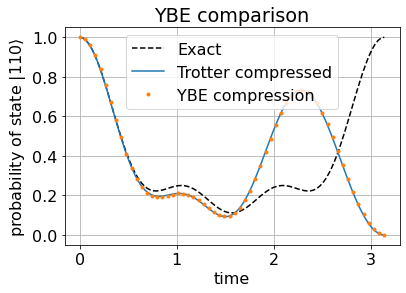

In [41]:
## Now plot the exact simulation, the Trotter compressed and the YBE equivalent
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
plt.plot(ts, probs_110_trott_c,color="C0",label="Trotter compressed")
plt.plot(ybe_ts, probs_110_ybe,color="C1",marker=".",linestyle="",label="YBE compression")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'YBE comparison')
plt.legend()
plt.grid()
plt.show()

As can be seen, at every time $t$ we are able to find a set of parameters that makes the YBE compressed circuit equivalent to the 24 CNOTs Trotter circuit.

From this moment on, we will be using this circuit for the challenge.

### 2.3 Variational compression - the pVQD algorithm

We showed that the YBE circuit is equivalent to the Trotter circuit with 4 Trotter steps.
For this reason, we will have the same accuracy.

We want to compress more Trotter steps into the same circuit, in order to gain accuracy without adding noise due to gate error rates. This can be done by using the pVQD algorithm optimize them.

We highlight that we are not modifying the circuit, instead we are optimizing the same gates in order to make the circuit contain a more accurate state.

In [42]:
def pvqd_overlap_and_gradient(left,right,state_wfn,parameters,shift,expectator,sampler):

	nparameters = len(parameters)
	# build dictionary of parameters to values
	# {left[0]: parameters[0], .. ., right[0]: parameters[0] + shift[0], ...}
	# First create the dictionary for overlap
	values_dict = [dict(zip(right[:] + left[:], parameters.tolist() + (parameters + shift).tolist()))]
		

	# Then the values for the gradient
	for i in range(nparameters):
		values_dict.append(dict(zip(right[:] + left[:], parameters.tolist() + (parameters + shift + ei(i,nparameters)*np.pi/2.0).tolist())))
		values_dict.append(dict(zip(right[:] + left[:], parameters.tolist() + (parameters + shift - ei(i,nparameters)*np.pi/2.0).tolist())))

	# Now evaluate the circuits with the parameters assigned

	results = []

	for values in values_dict:
		sampled_op = sampler.convert(state_wfn,params=values)

		mean  = sampled_op.eval().real
		est_err = 0

		results.append([mean,est_err])

	E = np.zeros(2)
	g = np.zeros((nparameters,2))

	E[0],E[1] = results[0]

	for i in range(nparameters):
		rplus  = results[1+2*i]
		rminus = results[2+2*i]
		# G      = (Ep - Em)/2
		# var(G) = var(Ep) * (dG/dEp)**2 + var(Em) * (dG/dEm)**2
		g[i,:] = (rplus[0]-rminus[0])/2.0,np.sqrt(rplus[1]**2+rminus[1]**2)/2.0

	return E,g 

Since we have $3$ rotations depending on $t$ for every compressed gate, this will result in a total of 15 parameters to optimize

In [43]:
# Here we put the optimization loop of the pVQD algorithm
backend       = Aer.get_backend('statevector_simulator')
instance      = QuantumInstance(backend=backend)
num_qubits    = 3

parameters    = np.zeros(15)
shift         = 0.01*np.ones(15)
params_vec    = ParameterVector('p',len(parameters))


dt            = np.pi/60
max_iter      = 100
n_steps       = 60
ths           = 0.9999



## Initialize quantities that will be equal all over the calculation
num_parameters = len(parameters)
# ParameterVector for left and right circuit

left  = ParameterVector('l', num_parameters)
right = ParameterVector('r', num_parameters)


## initialize useful quantities once
expectation = PauliExpectation()
sampler     = CircuitSampler(instance)

## Now prepare the state in order to compute the overlap and its gradient
# First use a single compressed Trotter step
U_dt      = Heisenberg_Trotter_compressed(num_qubits,1,t,dt)
ansatz    = Heisenberg_YBE_variational2(num_qubits,params_vec)

# Then, create the total circuit

l_circ     = ansatz.assign_parameters({params_vec: left})
r_circ     = ansatz.assign_parameters({params_vec: right})
zero_prj   = StateFn(projector_zero(U_dt.num_qubits),is_measurement = True)
total_circ = r_circ.compose(U_dt)+l_circ.inverse()
state_wfn  = expectation.convert(zero_prj @ StateFn(total_circ))

#######################################################

In [44]:
times = [i*dt for i in range(n_steps+1)]
tot_steps= 0
print("Running the algorithm")

pvqd_params = []
pvqd_params.append(list(parameters))


for i in range(n_steps):

    print('\n================================== \n')
    print("Time slice:",i+1)
    print("Shift before optimizing this step:",shift)
    print("Initial parameters:", parameters)
    print('\n================================== \n')

    count = 0
    overlap = [0.01,0]

    # Initialise quantities for the Adam optimiser
    m = np.zeros(num_parameters)
    v = np.zeros(num_parameters)


    while overlap[0] < ths and count < max_iter:
        print("Shift optimizing step:",count+1)
        count = count +1 

        ## Measure energy and gradient

        E,g = pvqd_overlap_and_gradient(left,right,state_wfn,parameters,shift,expectation,sampler)
        tot_steps = tot_steps+1


        print('Overlap',E[0])
        overlap = E
        #print('Gradient',g[:,0])


        meas_grad = np.asarray(g[:,0])
        shift = np.asarray(adam_gradient(parameters,shift,count,m,v,meas_grad))


    # Update parameters

    print('\n---------------------------------- \n')

    print("Shift after optimizing:",shift)
    print("New parameters:"        ,parameters + shift)
    print("New overlap: "          ,E[0])

    parameters = parameters + shift
    pvqd_params.append(list(parameters))

Running the algorithm


Time slice: 1
Shift before optimizing this step: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01]
Initial parameters: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Shift optimizing step: 1
Overlap 0.9881904977528884
Shift optimizing step: 2
Overlap 0.988766680753875
Shift optimizing step: 3
Overlap 0.9893166179576736
Shift optimizing step: 4
Overlap 0.9898399428658554
Shift optimizing step: 5
Overlap 0.9903364611467376
Shift optimizing step: 6
Overlap 0.9908062031220933
Shift optimizing step: 7
Overlap 0.9912494742717812
Shift optimizing step: 8
Overlap 0.9916669058296911
Shift optimizing step: 9
Overlap 0.9920594992164377
Shift optimizing step: 10
Overlap 0.9924286544090625
Shift optimizing step: 11
Overlap 0.9927761696052395
Shift optimizing step: 12
Overlap 0.9931041993169225
Shift optimizing step: 13
Overlap 0.9934151623808163
Shift optimizing step: 14
Overlap 0.9937116012798993
Shift optimizing step: 15
Overlap 0.993996007829

Overlap 0.9999267599029638

---------------------------------- 

Shift after optimizing: [ 0.0020528   0.01        0.0020528   0.05376349 -0.00396503 -0.02986015
  0.03574955  0.0337905  -0.03679175  0.07421389  0.03606903 -0.05133187
  0.0397712   0.04287603 -0.04204361]
New parameters: [ 0.00813728  0.04        0.00813728  0.22249544  0.02042116 -0.13079694
  0.1078729   0.16760334 -0.11100178  0.28379853  0.13501079 -0.19518479
  0.12253877  0.20441028 -0.13132647]
New overlap:  0.9999267599029638


Time slice: 5
Shift before optimizing this step: [ 0.0020528   0.01        0.0020528   0.05376349 -0.00396503 -0.02986015
  0.03574955  0.0337905  -0.03679175  0.07421389  0.03606903 -0.05133187
  0.0397712   0.04287603 -0.04204361]
Initial parameters: [ 0.00813728  0.04        0.00813728  0.22249544  0.02042116 -0.13079694
  0.1078729   0.16760334 -0.11100178  0.28379853  0.13501079 -0.19518479
  0.12253877  0.20441028 -0.13132647]


Shift optimizing step: 1
Overlap 0.9999327530754176



Overlap 0.9998724526590309
Shift optimizing step: 2
Overlap 0.9998952705656938
Shift optimizing step: 3
Overlap 0.9999083751007019

---------------------------------- 

Shift after optimizing: [ 0.00725211  0.01        0.00725211  0.0429353  -0.00165983 -0.01840015
  0.04907454  0.05235776 -0.05317266  0.05505709  0.05906211 -0.03164156
  0.05062189  0.0634812  -0.05188561]
New parameters: [ 0.04606297  0.12        0.04606297  0.61229034  0.00830971 -0.3270377
  0.44578358  0.50568088 -0.46455898  0.81003942  0.50252465 -0.53675303
  0.48694383  0.6092179  -0.51203732]
New overlap:  0.9999083751007019


Time slice: 13
Shift before optimizing this step: [ 0.00725211  0.01        0.00725211  0.0429353  -0.00165983 -0.01840015
  0.04907454  0.05235776 -0.05317266  0.05505709  0.05906211 -0.03164156
  0.05062189  0.0634812  -0.05188561]
Initial parameters: [ 0.04606297  0.12        0.04606297  0.61229034  0.00830971 -0.3270377
  0.44578358  0.50568088 -0.46455898  0.81003942  0.50252465 -0

Overlap 0.9997706464155364
Shift optimizing step: 2
Overlap 0.9998137605087087
Shift optimizing step: 3
Overlap 0.9998498105375723
Shift optimizing step: 4
Overlap 0.9998807835354555
Shift optimizing step: 5
Overlap 0.9999062808561064

---------------------------------- 

Shift after optimizing: [ 0.00805012  0.01        0.00805012  0.01182444 -0.03454161  0.01239429
  0.05966496  0.08452382 -0.08360455  0.02423088  0.04075324 -0.02477029
  0.08006859  0.0616022  -0.07881986]
New parameters: [ 0.11215098  0.19        0.11215098  0.79679765 -0.12604748 -0.34107045
  0.8378842   0.99211723 -0.9499123   1.07855805  0.88569944 -0.68615689
  0.94892981  1.09085779 -0.97346972]
New overlap:  0.9999062808561064


Time slice: 20
Shift before optimizing this step: [ 0.00805012  0.01        0.00805012  0.01182444 -0.03454161  0.01239429
  0.05966496  0.08452382 -0.08360455  0.02423088  0.04075324 -0.02477029
  0.08006859  0.0616022  -0.07881986]
Initial parameters: [ 0.11215098  0.19        0.11

Overlap 0.9997513286232267
Shift optimizing step: 3
Overlap 0.9998076728987821
Shift optimizing step: 4
Overlap 0.9998543524168947
Shift optimizing step: 5
Overlap 0.9998926223546415
Shift optimizing step: 6
Overlap 0.9999227806790263

---------------------------------- 

Shift after optimizing: [-0.00840806  0.01       -0.00840806  0.03237376 -0.04118677  0.01463203
  0.09327354  0.12797696 -0.12323127  0.02269288 -0.002733   -0.02069271
  0.11458491  0.03125857 -0.11213707]
New parameters: [ 0.10301878  0.26        0.10301878  0.92045864 -0.45734991 -0.1783091
  1.4054825   1.75938328 -1.70315413  1.30008015  0.99516216 -0.90305042
  1.65055024  1.38897649 -1.66519972]
New overlap:  0.9999227806790263


Time slice: 27
Shift before optimizing this step: [-0.00840806  0.01       -0.00840806  0.03237376 -0.04118677  0.01463203
  0.09327354  0.12797696 -0.12323127  0.02269288 -0.002733   -0.02069271
  0.11458491  0.03125857 -0.11213707]
Initial parameters: [ 0.10301878  0.26        0.103

Overlap 0.999830440032008
Shift optimizing step: 27
Overlap 0.9998445506836549
Shift optimizing step: 28
Overlap 0.9998574891288281
Shift optimizing step: 29
Overlap 0.9998693174024041
Shift optimizing step: 30
Overlap 0.9998801353582134
Shift optimizing step: 31
Overlap 0.999890071711309
Shift optimizing step: 32
Overlap 0.9998992673571826
Shift optimizing step: 33
Overlap 0.9999078557768576

---------------------------------- 

Shift after optimizing: [-0.01288822  0.01       -0.01288822  0.07572277 -0.11182761 -0.03648708
  0.04136501  0.08913221 -0.0879494  -0.0550766   0.02382836  0.04487483
  0.18610244 -0.03679047 -0.12480299]
New parameters: [ 0.05013608  0.3         0.05013608  1.16097874 -0.76193924 -0.24034795
  1.67687935  2.22328817 -2.11737266  1.23158412  1.00771165 -0.84920072
  2.25747518  1.37265357 -2.17507434]
New overlap:  0.9999078557768576


Time slice: 31
Shift before optimizing this step: [-0.01288822  0.01       -0.01288822  0.07572277 -0.11182761 -0.03648708


Overlap 0.9999098087116494

---------------------------------- 

Shift after optimizing: [ 0.0103216   0.01        0.0103216   0.03899607 -0.1357086  -0.02963318
 -0.02301071  0.00841567 -0.01850666 -0.11178595  0.09969428  0.12568283
  0.22304857 -0.06013858 -0.12726911]
New parameters: [ 0.05085146  0.33        0.05085146  1.32728381 -1.18441667 -0.373043
  1.66961684  2.32588326 -2.24489445  0.92296933  1.23202006 -0.54924326
  2.94646621  1.19429672 -2.55993297]
New overlap:  0.9999098087116494


Time slice: 34
Shift before optimizing this step: [ 0.0103216   0.01        0.0103216   0.03899607 -0.1357086  -0.02963318
 -0.02301071  0.00841567 -0.01850666 -0.11178595  0.09969428  0.12568283
  0.22304857 -0.06013858 -0.12726911]
Initial parameters: [ 0.05085146  0.33        0.05085146  1.32728381 -1.18441667 -0.373043
  1.66961684  2.32588326 -2.24489445  0.92296933  1.23202006 -0.54924326
  2.94646621  1.19429672 -2.55993297]


Shift optimizing step: 1
Overlap 0.9979662183001642
Shif

Overlap 0.9992002776436186
Shift optimizing step: 2
Overlap 0.999300967360019
Shift optimizing step: 3
Overlap 0.9993902667002911
Shift optimizing step: 4
Overlap 0.9994681337617345
Shift optimizing step: 5
Overlap 0.9995348508086603
Shift optimizing step: 6
Overlap 0.9995911785392501
Shift optimizing step: 7
Overlap 0.9996384404565957
Shift optimizing step: 8
Overlap 0.999678385228514
Shift optimizing step: 9
Overlap 0.9997128263270312
Shift optimizing step: 10
Overlap 0.9997433092260026
Shift optimizing step: 11
Overlap 0.9997709816140691
Shift optimizing step: 12
Overlap 0.9997966034928466
Shift optimizing step: 13
Overlap 0.9998206111229607
Shift optimizing step: 14
Overlap 0.9998432019311119
Shift optimizing step: 15
Overlap 0.9998644164210355
Shift optimizing step: 16
Overlap 0.9998842040992889
Shift optimizing step: 17
Overlap 0.9999024739226118

---------------------------------- 

Shift after optimizing: [ 0.00768986  0.01        0.00768986  0.03311355 -0.08740993  0.04101292


Overlap 0.9995700159616677
Shift optimizing step: 3
Overlap 0.9996456793384552
Shift optimizing step: 4
Overlap 0.9997121909173001
Shift optimizing step: 5
Overlap 0.9997705545579779
Shift optimizing step: 6
Overlap 0.9998208591168365
Shift optimizing step: 7
Overlap 0.9998632553935665
Shift optimizing step: 8
Overlap 0.9998983350180952
Shift optimizing step: 9
Overlap 0.9999268692389591

---------------------------------- 

Shift after optimizing: [ 0.02943312  0.01        0.02943312  0.0682115  -0.11335623  0.00069539
  0.0073247   0.08037829  0.01346255 -0.023627    0.12232413  0.06771809
  0.10387497  0.07076278 -0.01111394]
New parameters: [ 0.23688215  0.43        0.23688215  1.7362283  -2.13656889 -0.17452917
  1.53748962  2.74144419 -1.93117897  0.68501881  2.69993187  0.49572221
  4.27977444  1.48155585 -3.0523109 ]
New overlap:  0.9999268692389591


Time slice: 44
Shift before optimizing this step: [ 0.02943312  0.01        0.02943312  0.0682115  -0.11335623  0.00069539
  0.0

Overlap 0.9996183394831116
Shift optimizing step: 3
Overlap 0.9996689790109182
Shift optimizing step: 4
Overlap 0.9997074400909904
Shift optimizing step: 5
Overlap 0.9997369538449199
Shift optimizing step: 6
Overlap 0.9997599290312361
Shift optimizing step: 7
Overlap 0.9997784430969346
Shift optimizing step: 8
Overlap 0.9997945417352448
Shift optimizing step: 9
Overlap 0.9998097502761564
Shift optimizing step: 10
Overlap 0.999824908196967
Shift optimizing step: 11
Overlap 0.9998403899436141
Shift optimizing step: 12
Overlap 0.9998561922740377
Shift optimizing step: 13
Overlap 0.9998720194928101
Shift optimizing step: 14
Overlap 0.9998874419442756
Shift optimizing step: 15
Overlap 0.9999020289173352

---------------------------------- 

Shift after optimizing: [ 0.0269091   0.01        0.0269091   0.07790528 -0.09100182  0.0425167
  0.02789786  0.06524886  0.0054613   0.00532856  0.05764291  0.02354833
  0.11752778  0.13752409  0.00501347]
New parameters: [ 0.38162167  0.48        0.381

Overlap 0.9996484142219771
Shift optimizing step: 3
Overlap 0.9996931710679899
Shift optimizing step: 4
Overlap 0.9997254616452853
Shift optimizing step: 5
Overlap 0.9997524167194234
Shift optimizing step: 6
Overlap 0.9997773178738762
Shift optimizing step: 7
Overlap 0.9998004888203669
Shift optimizing step: 8
Overlap 0.9998216859291904
Shift optimizing step: 9
Overlap 0.9998412705615733
Shift optimizing step: 10
Overlap 0.9998599647597181
Shift optimizing step: 11
Overlap 0.9998781542158572
Shift optimizing step: 12
Overlap 0.9998956939539145
Shift optimizing step: 13
Overlap 0.9999121082266389

---------------------------------- 

Shift after optimizing: [ 0.01565335  0.01        0.01565335  0.08557163 -0.03320343  0.06763692
  0.05920637  0.02950862 -0.00409323  0.04237363  0.00683354  0.06550481
  0.11875191  0.09924641 -0.01463176]
New parameters: [ 0.47237658  0.53        0.47237658  2.49640924 -2.98871403  0.24021791
  1.86216986  3.37292412 -1.8999548   0.7538837   3.25896018  

Overlap 0.9998626566352737
Shift optimizing step: 8
Overlap 0.9998775813222538
Shift optimizing step: 9
Overlap 0.9998915212553083
Shift optimizing step: 10
Overlap 0.9999037357417915

---------------------------------- 

Shift after optimizing: [ 0.02617647  0.01        0.02617647  0.07189113 -0.01035394  0.02470797
  0.03755747  0.01338676 -0.02851608  0.07397541 -0.02503658  0.09949095
  0.094201    0.04648451 -0.03102815]
New parameters: [ 0.58774526  0.58        0.58774526  2.90330057 -3.05364252  0.45168171
  2.10469113  3.49174597 -2.00952766  1.08201761  3.21466654  1.35986727
  5.94157359  2.96201736 -3.17856363]
New overlap:  0.9999037357417915


Time slice: 59
Shift before optimizing this step: [ 0.02617647  0.01        0.02617647  0.07189113 -0.01035394  0.02470797
  0.03755747  0.01338676 -0.02851608  0.07397541 -0.02503658  0.09949095
  0.094201    0.04648451 -0.03102815]
Initial parameters: [ 0.58774526  0.58        0.58774526  2.90330057 -3.05364252  0.45168171
  2.1046

From the pVQD routine we get a list of parameters sets.

What we are interested in is the last set of parameters, corresponding to the evolution of the wavefunction at the final time $t=\pi$.

For completeness, we will also plot the probability of geting $|110\rangle$ throught the overall evolution.

In [20]:
def pvqd_probs_target(target,ansatz,param_list):

    ovp_list = []
    
    for params in param_list:
        circ  = ansatz(3,params)
        t_wfn = CircuitStateFn(circ)
        t_ovp = np.abs((~target@t_wfn).eval())**2

        ovp_list.append(t_ovp)

    return ovp_list

In [48]:
probs_110_pvqd   = ybe_probs_target(One^One^Zero,Heisenberg_YBE_variational,pvqd_params)

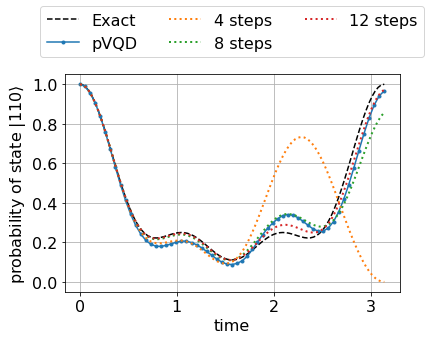

In [49]:
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
plt.plot(times,probs_110_pvqd,label="pVQD",marker=".",color="C0")
for (i,t_n) in enumerate(t_steps):
    plt.plot(ts, probs_110_trott[t_n],color="C"+str(i+1),label=str(t_n)+" steps",linewidth=2,linestyle="dotted")

plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
#plt.title(r'pVQD performance')
plt.legend(loc="upper center",bbox_to_anchor=(0.5, 1.35),ncol=3,fancybox=True)
plt.grid()
plt.show()

As can be seen, we have an improvement through the whole simulation, not just for the final state.
At $t \sim 1.5$ the Trotter approximation with $4$ steps starts detaching from the exact simulation, while the pVQD stay closer, with performances comparable to the 12 steps approximation.

We highlight that this technique is completely general: given a Trotter step $U(dt)$ we can compress its repeated application into a variational circuit of choice.

Moreover, this technique can also be performed entirely on hardware, as shown in [this article](https://arxiv.org/pdf/2112.12654.pdf).

In [50]:
#Here we show the parameters that we are going to use 
pvqd_opt_params = pvqd_params[-1]
pvqd_opt_params

[0.6382017062070897,
 0.5999999987484098,
 0.6382017062066773,
 3.0088034895496003,
 -3.0869200336945677,
 0.4709531470409451,
 2.163149581322057,
 3.480816125849344,
 -2.0741264452466974,
 1.2330206913091548,
 3.1275100711382064,
 1.593744340473751,
 6.107319841483039,
 3.0177717815840808,
 -3.24901805128811]

## 3- Final Implementation

### 3.1 Error mitigation

Here we will use error mitigation to further improve the result. In particular we will be using Zero Noise Extrapolation (ZNE). For this the circuit depth is extended by unfolding gates, $G \rightarrow G G^\dagger G$. The circuit remains the same this way (since $G^\dagger G = I$), though the noise is increased. This way we can obtain results for different noise levels and extrapolate to the ideal, zero noise case. This prodecure is nicely wrapped into a single function provided by [mitiq](https://mitiq.readthedocs.io/en/stable/from). One simply has to be careful with minor bugs present in mitiq, we will comment on them below. 

In [66]:
# Define the final circuit that is used to compute the fidelity 
fqr = QuantumRegister(7)
fqc = QuantumCircuit(fqr)
#fqc.rx(np.pi, [3, 5]) # Cannot use X gate due to a bug in mitq, rx(pi) does the same thing
fqc.id([0, 1, 2, 4, 6]) # Need to put identities since mitq cannot handle unused qubits
fqc.append(Heisenberg_YBE_variational(3,pvqd_opt_params), [fqr[1], fqr[3], fqr[5]])

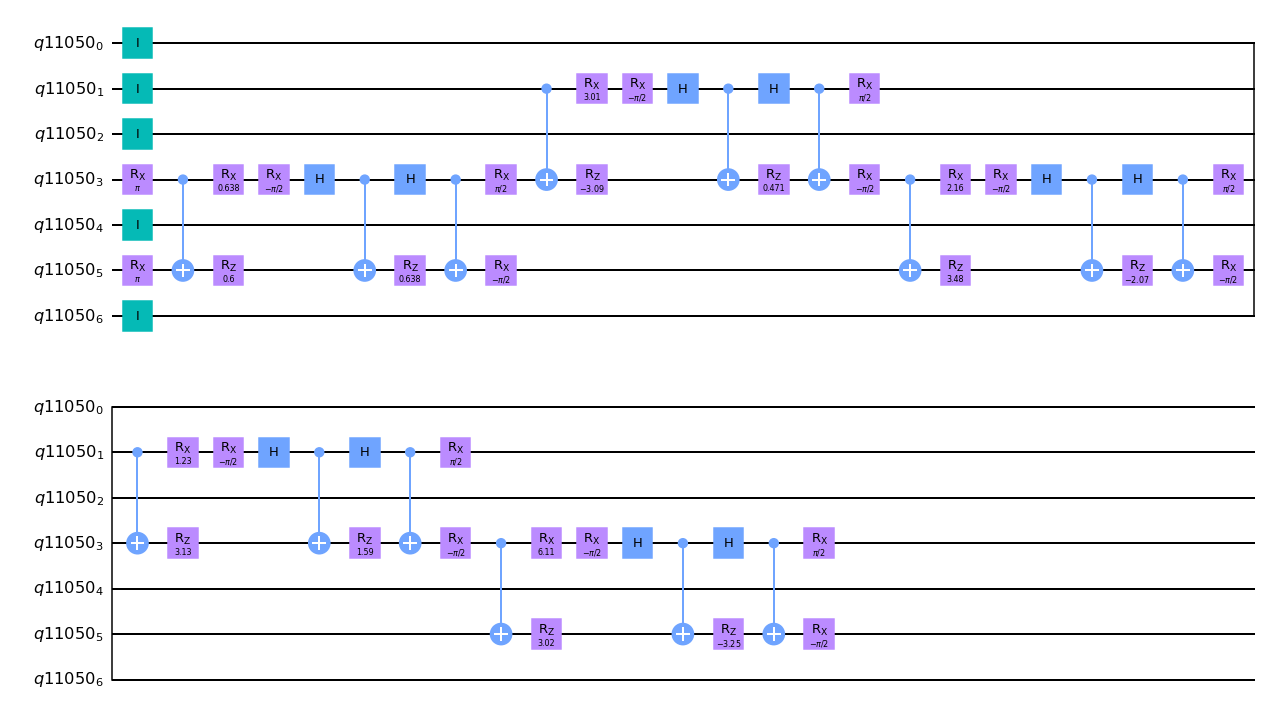

In [67]:
#fc = final_circ(ybe_optimal)
fqc.decompose().draw(output="mpl")

In [53]:
from mitiq import zne
from qiskit.result import Result
from qiskit.result.models import ExperimentResult
from qiskit.result.models import ExperimentResultData
from qiskit.result.models import QobjExperimentHeader

In [54]:
provider = IBMQ.load_account()

In [55]:
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
#jakarta = provider.get_backend('ibmq_jakarta')
# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

In [56]:
# Setting all the parameters that are need
shots = 8192
backend = sim_noisy_jakarta

In [57]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

In [58]:
def zne_results(tomo_circs, backend, optimization_level, zne_order, shots):

    # This function runs the tomography circuits and unrolls the gates to increase the noise level
    # The counts that are obtained for the differnt noise levels are then extrapolated to the zero-noise level

    zne_result_list = []
    scale_factors = [1.0, 2.0, 3.0]
    # Loop over the tomography circuits
    for circ in tomo_circs:

         # Unfold the tomography circuit by a scale factor and evaluate them 
        noise_scaled_circuits = [zne.scaling.fold_global(circ, s) for s in scale_factors]  
        result_list = [execute(circ_noise, backend=backend, optimization_level=optimization_level, shots=shots).result() for circ_noise in noise_scaled_circuits]

        counts_dict = {}
        ordered_bitstrings = dict(sorted(result_list[0].get_counts().items()))
        # Loop over the results of the scaled circuits and collect the data in the correct form
        for key in ordered_bitstrings.keys():
            counts_list = []
            for result in result_list:
                counts_list.append(result.get_counts()[key])
            # Here we extrapolate the counts to zero noise and round to the closest integer 
            zne_counts_value = int(zne.PolyFactory.extrapolate(scale_factors, counts_list, order=zne_order)) 
            if zne_counts_value < 0:
                zne_counts_value = 0
            counts_dict[key] = zne_counts_value
        zne_result_list.append(counts_dict)
        
    # To work with the StateTomographyFitter we need to put the result into a Qiskit Result() object
    name_list = [circ.name for circ in tomo_circs]
    results_tmp = [[ExperimentResult(shots=shots, success=True, data=ExperimentResultData(counts=result_i), header=QobjExperimentHeader(name=name_i))] for (name_i, result_i) in zip(name_list, zne_result_list)]
    results = [Result(backend_name="zne", backend_version="zne", qobj_id='0', job_id='0', success=True, results=result_i) for result_i in results_tmp]

    return results 


In [68]:
# Create the tomography circuits
st_qcs = state_tomography_circuits(fqc.decompose(), [fqr[1], fqr[3], fqr[5]])

In [71]:
# Repeat fidelity measurement
reps = 1 # Needs to be 8 in the final execution
fids = []
for _ in range(reps):
    
    zne_res = zne_results(st_qcs, backend=backend, optimization_level=3, zne_order=2, shots=shots)
    fids.append(state_tomo(zne_res, st_qcs)) 

In [72]:
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.7100 ± 0.0051
